In [1]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd 
import os
import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from tqdm import tqdm

In [2]:
movies  = pd.read_csv('/kaggle/input/movierecommenderdataset/movies.csv')
ratings  = pd.read_csv('/kaggle/input/movierecommenderdataset/ratings.csv')

ratings_origin = ratings

In [3]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Splitting data into smaller chunks containg only top x most active users and x most watched movies. Movie indexes where not consistent with their IDs (for 9742 uniqe movies the highest id is 193609), so to make it easier to use Embeddings Layers it's better to make them in range 0 to number of unique movies in dataset. Shrinking data to lower number of unique users/movies create this problem as well. 
Code below creates dictionaries holding information about previousID : newID.


In [4]:
def get_top_data(ratings_origin, user_size, movie_size):

    top_users = ratings_origin.userId.value_counts()[:user_size].index
    ratings_origin = ratings_origin.loc[ratings_origin['userId'].isin(top_users)]

    top_movies = ratings_origin.movieId.value_counts()[:movie_size].index
    ratings_origin = ratings_origin.loc[ratings_origin['movieId'].isin(top_movies)]

    tmp_movieIds = ratings_origin.movieId.unique()
    movie_set = {}
    user_set = {}
    for count, movie in enumerate(tmp_movieIds):
        movie_set[movie] = count 

    tmp_userIds = ratings_origin.userId.unique()
    for count, user in enumerate(tmp_userIds):
        user_set[user] = count 
    
    inv_movie_set = {v:k for k, v in movie_set.items()}
    inv_user_set = {v:k for k, v in user_set.items()}

    ratings_origin['movieId'] =  ratings_origin['movieId'].map(movie_set)
    ratings_origin['userId'] =  ratings_origin['userId'].map(user_set)
    
    return ratings_origin, movie_set, user_set, inv_movie_set, inv_user_set

In [5]:
ratings_top, movie_set, user_set, inv_movie_set, inv_user_set=  get_top_data(ratings_origin, 50, 50)

In [6]:
class cf_dataset:
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, x):
        user_id =  self.df.iloc[x][['userId']].values[0]
        movie_id = self.df.iloc[x][['movieId']].values[0]
        user_rating =  self.df.iloc[x]['rating']
        
        return torch.tensor([[user_id, movie_id]], dtype=torch.long), torch.tensor(user_rating, dtype=torch.float)

In [7]:
split_size = 0.8
msk = np.random.rand(len(ratings_top)) < split_size

train_ratings = ratings_top[msk]

test_ratings = ratings_top[~msk]

train_dataset = cf_dataset(train_ratings)
test_dataset = cf_dataset(test_ratings)
print(len(train_ratings), len(test_ratings), train_dataset[0])

1669 380 (tensor([[0, 0]]), tensor(3.5000))


In [8]:
class Model(nn.Module):
    def __init__(self, n_users, n_movies, n_factors):
        super().__init__()
        self.users = nn.Embedding(n_users, n_factors)
        self.movies = nn.Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.users(x[:, 0])
        movies = self.movies(x[:, 1])
        return (users*movies).sum(dim=1)


In [9]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

criterion = torch.nn.MSELoss()
n_of_unique_users, n_of_unique_movies, n_factors = len(ratings_origin.userId.unique()), len(ratings_origin.movieId.unique()), 5 
model = Model(n_of_unique_users, n_of_unique_movies, n_factors)
model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2)

In [10]:
def train(model, dataloader, criterion, opt, epoch, total_epochs, verbose=False):
    
    model.train()
    epoch_loss = 0.0
    for data, rating in tqdm(dataloader):

        data, rating = data.to(device), rating.to(device)
        output = model(data.squeeze(1))
        
        loss = criterion(output, rating)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss
    if verbose:
        print(f'Training : Epoch: {epoch + 1} / {total_epochs} Current loss: {(epoch_loss / len(dataloader)):4f}')
    
    return model, (epoch_loss / len(dataloader)).detach().cpu().item()

In [11]:
def validate(model, dataloader, criterion, opt, epoch, total_epochs, verbose=False):
    model.eval()
    
    with torch.no_grad():
        val_loss = 0.0
        for data, rating in tqdm(dataloader):
            data, rating = data.to(device), rating.to(device)
            
            output = model(data.squeeze(1))
            
            loss = criterion(output, rating)
            val_loss += loss
        if verbose:
            print(f'Validation : Epoch: {epoch + 1} / {total_epochs} Current loss: {(val_loss / len(dataloader)):4f}')
        
    return (val_loss / len(dataloader)).detach().cpu().item()

In [12]:
def plot_results(train_losses, val_losses, i, ax, emb_user, emb_movie, factor):
    ax[int(i / 2), i % 2].plot(train_losses, label='train loss')
    ax[int(i / 2), i % 2].plot(val_losses, label='val loss')
    ax[int(i / 2), i % 2].set_xlabel('Epochs')
    ax[int(i / 2), i % 2].set_ylabel('MSE')
    ax[int(i / 2), i % 2].title.set_text(f'top users: {emb_user}'
                                              f', top_movies: {emb_movie}'
                                              f' n_factor: {factor}')

In [13]:
def create_dataloaders(split_size,n_users, n_movies):
    ratings_top, movie_set, user_set, inv_movie_set, inv_user_set=  get_top_data(ratings_origin, n_users, n_movies)
    split_size = split_size
    msk = np.random.rand(len(ratings_top)) < split_size
    train_ratings = ratings_top[msk]
    test_ratings = ratings_top[~msk]

    train_dataset = cf_dataset(train_ratings)
    test_dataset = cf_dataset(test_ratings)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
    val_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
    return train_dataloader, val_dataloader

*************************emb_user: 50, emb_movie: 50 factor: 5*************************


100%|██████████| 26/26 [00:00<00:00, 43.98it/s]


Training : Epoch: 1 / 21 Current loss: 20.490
Validation : Epoch: 1 / 21 Current loss: 17.995083


100%|██████████| 26/26 [00:00<00:00, 43.91it/s]


Training : Epoch: 6 / 21 Current loss: 14.481
Validation : Epoch: 6 / 21 Current loss: 14.541513


100%|██████████| 26/26 [00:00<00:00, 44.55it/s]


Training : Epoch: 11 / 21 Current loss: 8.713
Validation : Epoch: 11 / 21 Current loss: 9.448717


100%|██████████| 26/26 [00:00<00:00, 44.41it/s]


Training : Epoch: 16 / 21 Current loss: 3.717
Validation : Epoch: 16 / 21 Current loss: 4.566818


100%|██████████| 26/26 [00:00<00:00, 45.55it/s]


Training : Epoch: 21 / 21 Current loss: 1.609
Validation : Epoch: 21 / 21 Current loss: 2.303634
*************************emb_user: 50, emb_movie: 50 factor: 15*************************


100%|██████████| 26/26 [00:00<00:00, 44.70it/s]


Training : Epoch: 1 / 21 Current loss: 31.532
Validation : Epoch: 1 / 21 Current loss: 26.256884


100%|██████████| 26/26 [00:00<00:00, 44.63it/s]


Training : Epoch: 6 / 21 Current loss: 19.198
Validation : Epoch: 6 / 21 Current loss: 22.312000


100%|██████████| 26/26 [00:00<00:00, 43.90it/s]


Training : Epoch: 11 / 21 Current loss: 12.904
Validation : Epoch: 11 / 21 Current loss: 18.350325


100%|██████████| 26/26 [00:00<00:00, 44.44it/s]


Training : Epoch: 16 / 21 Current loss: 6.605
Validation : Epoch: 16 / 21 Current loss: 12.008128


100%|██████████| 26/26 [00:00<00:00, 44.32it/s]


Training : Epoch: 21 / 21 Current loss: 2.785
Validation : Epoch: 21 / 21 Current loss: 7.132348
*************************emb_user: 150, emb_movie: 150 factor: 5*************************


100%|██████████| 145/145 [00:03<00:00, 44.19it/s]


Training : Epoch: 1 / 21 Current loss: 20.181
Validation : Epoch: 1 / 21 Current loss: 19.351433


100%|██████████| 145/145 [00:03<00:00, 45.59it/s]


Training : Epoch: 6 / 21 Current loss: 15.657
Validation : Epoch: 6 / 21 Current loss: 16.593447


100%|██████████| 145/145 [00:03<00:00, 45.67it/s]


Training : Epoch: 11 / 21 Current loss: 8.572
Validation : Epoch: 11 / 21 Current loss: 8.871870


100%|██████████| 145/145 [00:03<00:00, 45.63it/s]


Training : Epoch: 16 / 21 Current loss: 1.869
Validation : Epoch: 16 / 21 Current loss: 2.240504


100%|██████████| 145/145 [00:03<00:00, 45.64it/s]


Training : Epoch: 21 / 21 Current loss: 0.948
Validation : Epoch: 21 / 21 Current loss: 1.246603
*************************emb_user: 150, emb_movie: 150 factor: 15*************************


100%|██████████| 148/148 [00:03<00:00, 45.24it/s]


Training : Epoch: 1 / 21 Current loss: 28.621
Validation : Epoch: 1 / 21 Current loss: 26.775177


100%|██████████| 148/148 [00:03<00:00, 45.30it/s]


Training : Epoch: 6 / 21 Current loss: 14.791
Validation : Epoch: 6 / 21 Current loss: 17.973419


100%|██████████| 148/148 [00:03<00:00, 46.13it/s]


Training : Epoch: 11 / 21 Current loss: 4.606
Validation : Epoch: 11 / 21 Current loss: 6.845470


100%|██████████| 148/148 [00:03<00:00, 44.90it/s]


Training : Epoch: 16 / 21 Current loss: 1.766
Validation : Epoch: 16 / 21 Current loss: 3.431541


100%|██████████| 148/148 [00:03<00:00, 45.57it/s]


Training : Epoch: 21 / 21 Current loss: 1.177
Validation : Epoch: 21 / 21 Current loss: 2.537665
*************************emb_user: 250, emb_movie: 250 factor: 5*************************


100%|██████████| 279/279 [00:06<00:00, 45.59it/s]


Training : Epoch: 1 / 21 Current loss: 19.098
Validation : Epoch: 1 / 21 Current loss: 19.011425


100%|██████████| 279/279 [00:06<00:00, 45.60it/s]


Training : Epoch: 6 / 21 Current loss: 13.829
Validation : Epoch: 6 / 21 Current loss: 14.776688


100%|██████████| 279/279 [00:06<00:00, 45.89it/s]


Training : Epoch: 11 / 21 Current loss: 4.243
Validation : Epoch: 11 / 21 Current loss: 4.562168


100%|██████████| 279/279 [00:06<00:00, 45.60it/s]


Training : Epoch: 16 / 21 Current loss: 1.358
Validation : Epoch: 16 / 21 Current loss: 1.790243


100%|██████████| 279/279 [00:06<00:00, 45.51it/s]


Training : Epoch: 21 / 21 Current loss: 0.916
Validation : Epoch: 21 / 21 Current loss: 1.261406
*************************emb_user: 250, emb_movie: 250 factor: 15*************************


100%|██████████| 279/279 [00:06<00:00, 45.23it/s]


Training : Epoch: 1 / 21 Current loss: 27.494
Validation : Epoch: 1 / 21 Current loss: 25.060465


100%|██████████| 279/279 [00:06<00:00, 45.63it/s]


Training : Epoch: 6 / 21 Current loss: 12.745
Validation : Epoch: 6 / 21 Current loss: 14.599220


100%|██████████| 279/279 [00:06<00:00, 45.52it/s]


Training : Epoch: 11 / 21 Current loss: 3.417
Validation : Epoch: 11 / 21 Current loss: 4.943166


100%|██████████| 279/279 [00:06<00:00, 44.95it/s]


Training : Epoch: 16 / 21 Current loss: 1.576
Validation : Epoch: 16 / 21 Current loss: 2.820013


100%|██████████| 279/279 [00:06<00:00, 44.71it/s]


Training : Epoch: 21 / 21 Current loss: 1.110
Validation : Epoch: 21 / 21 Current loss: 2.165754
*************************emb_user: 500, emb_movie: 500 factor: 5*************************


100%|██████████| 527/527 [00:11<00:00, 45.81it/s]


Training : Epoch: 1 / 21 Current loss: 18.735
Validation : Epoch: 1 / 21 Current loss: 17.881311


100%|██████████| 527/527 [00:11<00:00, 45.56it/s]


Training : Epoch: 6 / 21 Current loss: 12.447
Validation : Epoch: 6 / 21 Current loss: 12.508023


100%|██████████| 527/527 [00:11<00:00, 45.78it/s]


Training : Epoch: 11 / 21 Current loss: 3.709
Validation : Epoch: 11 / 21 Current loss: 3.905467


100%|██████████| 527/527 [00:11<00:00, 45.72it/s]


Training : Epoch: 16 / 21 Current loss: 1.539
Validation : Epoch: 16 / 21 Current loss: 1.840564


100%|██████████| 527/527 [00:11<00:00, 45.75it/s]


Training : Epoch: 21 / 21 Current loss: 1.026
Validation : Epoch: 21 / 21 Current loss: 1.301505
*************************emb_user: 500, emb_movie: 500 factor: 15*************************


100%|██████████| 524/524 [00:11<00:00, 45.25it/s]


Training : Epoch: 1 / 21 Current loss: 27.050
Validation : Epoch: 1 / 21 Current loss: 24.013874


100%|██████████| 524/524 [00:11<00:00, 45.67it/s]


Training : Epoch: 6 / 21 Current loss: 10.904
Validation : Epoch: 6 / 21 Current loss: 12.387405


100%|██████████| 524/524 [00:11<00:00, 44.14it/s]


Training : Epoch: 11 / 21 Current loss: 3.277
Validation : Epoch: 11 / 21 Current loss: 5.035313


100%|██████████| 524/524 [00:13<00:00, 38.42it/s]


Training : Epoch: 16 / 21 Current loss: 1.683
Validation : Epoch: 16 / 21 Current loss: 3.222327


100%|██████████| 524/524 [00:11<00:00, 45.16it/s]


Training : Epoch: 21 / 21 Current loss: 1.187
Validation : Epoch: 21 / 21 Current loss: 2.545661
*************************emb_user: 610, emb_movie: 9724 factor: 5*************************


100%|██████████| 1265/1265 [00:27<00:00, 45.35it/s]


Training : Epoch: 1 / 21 Current loss: 16.940
Validation : Epoch: 1 / 21 Current loss: 15.503139


100%|██████████| 1265/1265 [00:35<00:00, 35.54it/s]


Training : Epoch: 6 / 21 Current loss: 13.283
Validation : Epoch: 6 / 21 Current loss: 13.565064


100%|██████████| 1265/1265 [00:32<00:00, 39.20it/s]


Training : Epoch: 11 / 21 Current loss: 9.470
Validation : Epoch: 11 / 21 Current loss: 9.567783


100%|██████████| 1265/1265 [00:28<00:00, 44.27it/s]


Training : Epoch: 16 / 21 Current loss: 5.565
Validation : Epoch: 16 / 21 Current loss: 5.982702


100%|██████████| 1265/1265 [00:27<00:00, 46.24it/s]


Training : Epoch: 21 / 21 Current loss: 3.871
Validation : Epoch: 21 / 21 Current loss: 4.404381
*************************emb_user: 610, emb_movie: 9724 factor: 15*************************


100%|██████████| 1253/1253 [00:27<00:00, 45.47it/s]


Training : Epoch: 1 / 21 Current loss: 22.856
Validation : Epoch: 1 / 21 Current loss: 19.560665


100%|██████████| 1253/1253 [00:27<00:00, 45.08it/s]


Training : Epoch: 6 / 21 Current loss: 12.615
Validation : Epoch: 6 / 21 Current loss: 14.135685


100%|██████████| 1253/1253 [00:27<00:00, 45.04it/s]


Training : Epoch: 11 / 21 Current loss: 7.361
Validation : Epoch: 11 / 21 Current loss: 9.018228


100%|██████████| 1253/1253 [00:27<00:00, 45.20it/s]


Training : Epoch: 16 / 21 Current loss: 4.654
Validation : Epoch: 16 / 21 Current loss: 6.334814


100%|██████████| 1253/1253 [00:27<00:00, 45.62it/s]


Training : Epoch: 21 / 21 Current loss: 3.403
Validation : Epoch: 21 / 21 Current loss: 5.040884


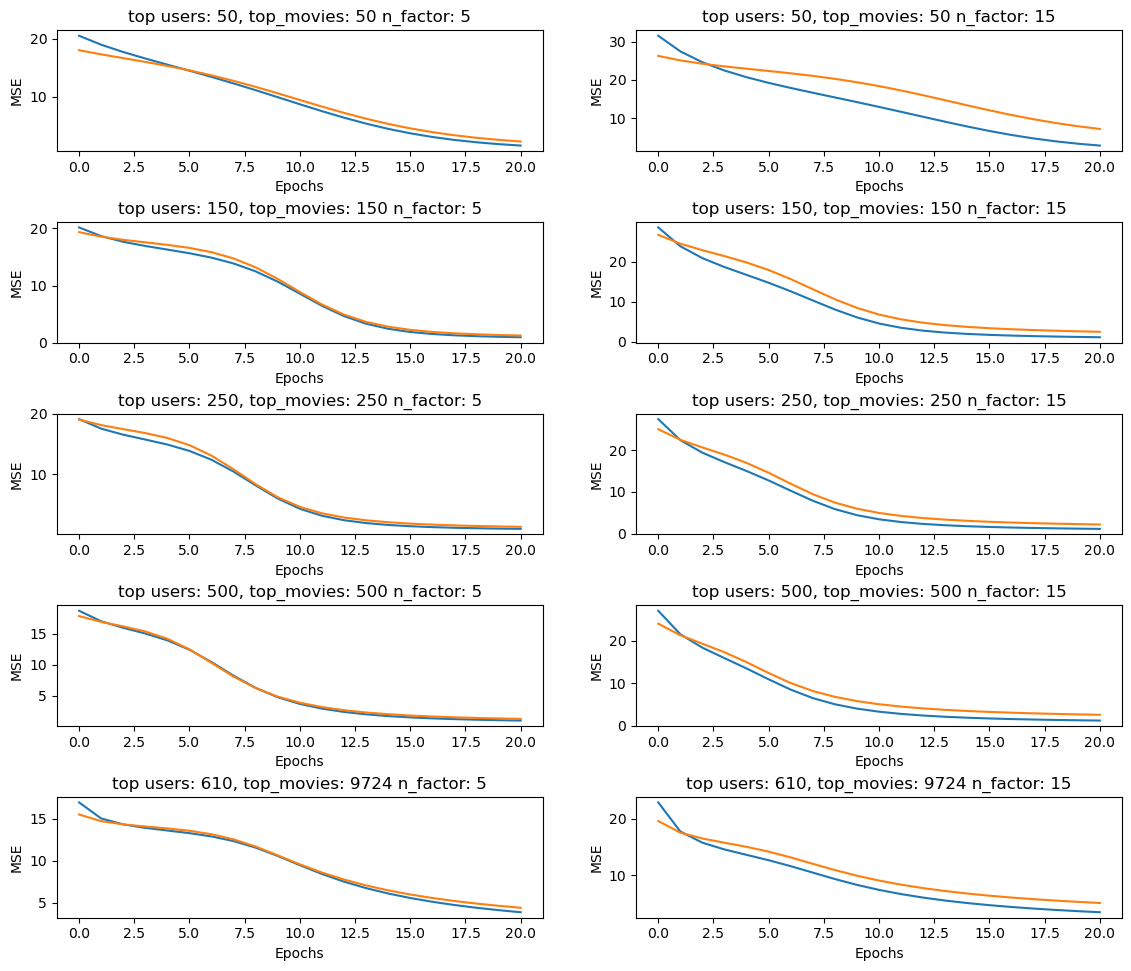

In [14]:
epochs = 21
device = ('cuda' if torch.cuda.is_available() else 'cpu')

criterion = torch.nn.MSELoss()

different_ens_sizes = [[50,50], [150,150], [250,250], 
                       [500,500], [n_of_unique_users, n_of_unique_movies]]

n_factors = [5, 15]

fig, ax = plt.subplots(len(different_ens_sizes), len(n_factors), figsize=(12,10))
fig.tight_layout(pad=3.0)

i = 0
for emb_user, emb_movie in different_ens_sizes:
    for factor in n_factors:
        print('*' * 25 + f'emb_user: {emb_user}, emb_movie: {emb_movie}'
              f' factor: {factor}' + '*' * 25)
        train_dataloader, val_dataloader = create_dataloaders(split_size=0.8,n_users=emb_user, n_movies=emb_movie)
        train_losses = []
        val_losses = []
        model = Model(emb_user, emb_movie, factor)
        model.to(device)
        opt = torch.optim.SGD(model.parameters(), lr=1e-2)
        
        for epoch in range(epochs):

            model, training_loss = train(model, train_dataloader, criterion, opt, epoch, epochs)
            val_loss = validate(model, val_dataloader, criterion, opt, epoch, epochs)
            train_losses.append(training_loss)
            val_losses.append(val_loss)
            if epoch % 5 == 0:
                print(f'Training : Epoch: {epoch + 1} / {epochs}' 
                      f' Current loss: {train_losses[epoch]:.3f}')
                print(f'Validation : Epoch: {epoch + 1} / {epochs}' 
                      f' Current loss: {val_losses[epoch]:3f}')

        plot_results(train_losses, val_losses, i, ax, emb_user, emb_movie, factor)
        i += 1
plt.show()

Trainging one model to test predictions of movies based on cosine similariity of their embeddings

In [15]:
emb_user ,emb_movie, factor = 50, 50, 5

epochs = 10
train_losses = []
val_losses = []
train_dataloader, val_dataloader = create_dataloaders(split_size=0.8,n_users=emb_user, n_movies=emb_movie)
train_losses = []
val_losses = []
model = Model(emb_user, emb_movie, factor)
model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2)

print('-' * 50)
for epoch in range(epochs):
    model, training_loss = train(model, train_dataloader, criterion, opt, epoch, epochs, True)
    val_loss = validate(model, test_dataloader, criterion, opt, epoch, epochs, True)
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
print('-' * 50)

--------------------------------------------------


100%|██████████| 103/103 [00:02<00:00, 45.19it/s]


Training : Epoch: 1 / 10 Current loss: 20.019550


100%|██████████| 24/24 [00:00<00:00, 45.47it/s]


Validation : Epoch: 1 / 10 Current loss: 18.419439


100%|██████████| 103/103 [00:02<00:00, 45.30it/s]


Training : Epoch: 2 / 10 Current loss: 18.992243


100%|██████████| 24/24 [00:00<00:00, 45.98it/s]


Validation : Epoch: 2 / 10 Current loss: 17.721842


100%|██████████| 103/103 [00:02<00:00, 44.64it/s]


Training : Epoch: 3 / 10 Current loss: 18.199734


100%|██████████| 24/24 [00:00<00:00, 46.32it/s]


Validation : Epoch: 3 / 10 Current loss: 17.171991


100%|██████████| 103/103 [00:02<00:00, 45.70it/s]


Training : Epoch: 4 / 10 Current loss: 17.553274


100%|██████████| 24/24 [00:00<00:00, 46.44it/s]


Validation : Epoch: 4 / 10 Current loss: 16.709862


100%|██████████| 103/103 [00:02<00:00, 45.73it/s]


Training : Epoch: 5 / 10 Current loss: 16.995333


100%|██████████| 24/24 [00:00<00:00, 45.81it/s]


Validation : Epoch: 5 / 10 Current loss: 16.293995


100%|██████████| 103/103 [00:02<00:00, 44.86it/s]


Training : Epoch: 6 / 10 Current loss: 16.485203


100%|██████████| 24/24 [00:00<00:00, 46.43it/s]


Validation : Epoch: 6 / 10 Current loss: 15.892918


100%|██████████| 103/103 [00:02<00:00, 45.22it/s]


Training : Epoch: 7 / 10 Current loss: 15.991432


100%|██████████| 24/24 [00:00<00:00, 46.50it/s]


Validation : Epoch: 7 / 10 Current loss: 15.480401


100%|██████████| 103/103 [00:02<00:00, 45.30it/s]


Training : Epoch: 8 / 10 Current loss: 15.487609


100%|██████████| 24/24 [00:00<00:00, 46.04it/s]


Validation : Epoch: 8 / 10 Current loss: 15.032837


100%|██████████| 103/103 [00:02<00:00, 45.38it/s]


Training : Epoch: 9 / 10 Current loss: 14.950108


100%|██████████| 24/24 [00:00<00:00, 46.26it/s]


Validation : Epoch: 9 / 10 Current loss: 14.528018


100%|██████████| 103/103 [00:02<00:00, 45.39it/s]


Training : Epoch: 10 / 10 Current loss: 14.357172


100%|██████████| 24/24 [00:00<00:00, 46.24it/s]

Validation : Epoch: 10 / 10 Current loss: 13.945053
--------------------------------------------------


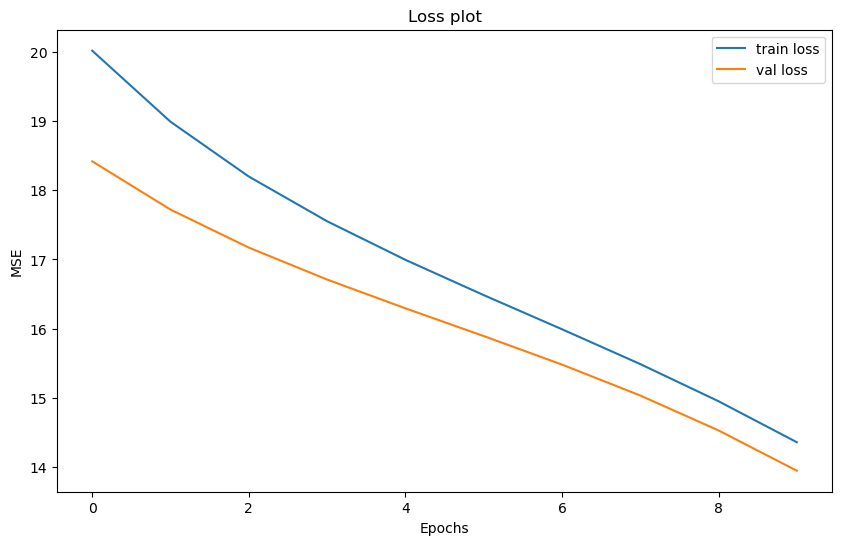

In [16]:
plt.figure(figsize=(10, 6))
plt.title('Loss plot')
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [17]:
def predict_movies(embedding, idx, movies_df, n_movies):
    
    all_embedings = model.movies(torch.arange(0, n_movies)).tolist()
    index = (model.movies(torch.tensor([idx])).detach().numpy())

    similarity = cosine_similarity(index, all_embedings)[0]  

    top = np.where(similarity > 0.7)[0]
    top = np.delete(top, np.where(top == idx))
    
    scores = similarity[top]

    embedding_id = [inv_movie_set[result] for result in top]
    titles = movies.loc[movies['movieId'].isin(embedding_id)]
    result_df = titles[['movieId','title']]
    result_df['score'] = scores
    result_df.sort_values(by='score', ascending=False, inplace=True)
        
    return similarity, result_df

In [18]:
similarity, results_df = predict_movies('movie', 3, movies, emb_movie)
results_df

,movieId,title,score
2836,3793,X-Men (2000),0.873699
1267,1682,"Truman Show, The (1998)",0.833317
510,593,"Silence of the Lambs, The (1991)",0.826678
4615,6874,Kill Bill: Vol. 1 (2003),0.731933
